In [1]:
import os
import json

from PIL import Image

import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
torch.manual_seed(13)

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet152

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

Load mapping of encoded categories into human-readable names

In [2]:
with open("flower_data/cat_to_name.json") as f: cat_to_name = json.load(f)

# converting string keys originally stored in JSON file to integer keys
cat_to_name = {int(key): value for (key, value) in cat_to_name.items()}

n_classes = len(cat_to_name)
    
print("%d categories!" % n_classes)

102 categories!


Create datasets (with transforms) and dataloaders:

In [3]:
normalize = transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(45),
                                      transforms.ToTensor(),
                                      normalize])

valid_transform  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       normalize])

train_dataset = ImageFolder("flower_data/train", transform=train_transform)
valid_dataset = ImageFolder("flower_data/valid", transform=valid_transform)

batch_size  = 64
num_workers = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

Figure out a device to be used while training / evaluating neural networks:

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Use a pretrained ResNet-152 (because of the lowerst TOP-1 error):

In [ ]:
model = resnet152(pretrained=True)

for param in model.parameters(): param.requires_grad = False
    
model.fc = nn.Linear(2048, n_classes)

model.to(device);

Define loss function, optimizer and tracked metrics:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

step = 0
cum_train_loss = 0.
valid_loss_min = np.Inf
train_losses, valid_losses, valid_accuracies = [], [], []

Train and evaluate the neural network:

In [9]:
n_epochs  = 35
log_every = 50

for epoch in range(n_epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        logits = model.forward(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cum_train_loss += loss.item()

        if step and step % log_every == 0:
            cum_valid_loss = 0.
            cum_valid_accuracy = 0

            model.eval()

            with torch.no_grad():
                for x, y in valid_loader:
                    x, y = x.to(device), y.to(device)

                    logits = model.forward(x)
                    loss = criterion(logits, y)
                    cum_valid_loss += loss.item()

                    ps = torch.softmax(logits, dim=1)
                    top_p, top_class = ps.topk(1, dim=1)
                    cum_valid_accuracy += (y == top_class.view(-1)).float().mean()

            model.train()

            train_loss = cum_train_loss / log_every
            train_losses.append(train_loss)

            valid_loss = cum_valid_loss / len(valid_loader)
            valid_losses.append(valid_loss)

            valid_accuracy = cum_valid_accuracy / len(valid_loader)
            valid_accuracies.append(valid_accuracy)

            cum_train_loss = 0.

            print("Epoch: %2d/%2d"          % (epoch + 1, n_epochs),
                  "Step: %4d"               % (step),
                  "Train loss: %.4f"        % (train_loss),
                  "Valid loss: %.4f"        % (valid_loss),
                  "Valid accuracy: %2.3f%%" % (valid_accuracy * 100),
                  sep=" | ")

            if valid_loss < valid_loss_min:
                print("Valid loss decreased: %.4f => %.4f | Saving model..." % (valid_loss_min, valid_loss))
                torch.save(model.fc.state_dict(), "model.fc.pt")
                valid_loss_min = valid_loss

        step += 1

Epoch:  1/10 | Step: 2575 | Train loss: 0.4220 | Valid loss: 0.3393 | Valid accuracy: 91.096%
Epoch:  1/10 | Step: 2600 | Train loss: 0.4337 | Valid loss: 0.3265 | Valid accuracy: 91.317%
Epoch:  1/10 | Step: 2625 | Train loss: 0.4617 | Valid loss: 0.3312 | Valid accuracy: 91.404%
Epoch:  1/10 | Step: 2650 | Train loss: 0.4696 | Valid loss: 0.3140 | Valid accuracy: 92.139%
Epoch:  1/10 | Step: 2675 | Train loss: 0.4735 | Valid loss: 0.3650 | Valid accuracy: 89.928%
Epoch:  2/10 | Step: 2700 | Train loss: 0.4242 | Valid loss: 0.3211 | Valid accuracy: 91.144%
Epoch:  2/10 | Step: 2725 | Train loss: 0.4133 | Valid loss: 0.3443 | Valid accuracy: 91.438%
Epoch:  2/10 | Step: 2750 | Train loss: 0.4676 | Valid loss: 0.3161 | Valid accuracy: 91.558%
Epoch:  2/10 | Step: 2775 | Train loss: 0.4781 | Valid loss: 0.3228 | Valid accuracy: 91.385%
Epoch:  3/10 | Step: 2800 | Train loss: 0.4210 | Valid loss: 0.3130 | Valid accuracy: 92.827%
Epoch:  3/10 | Step: 2825 | Train loss: 0.4413 | Valid loss:

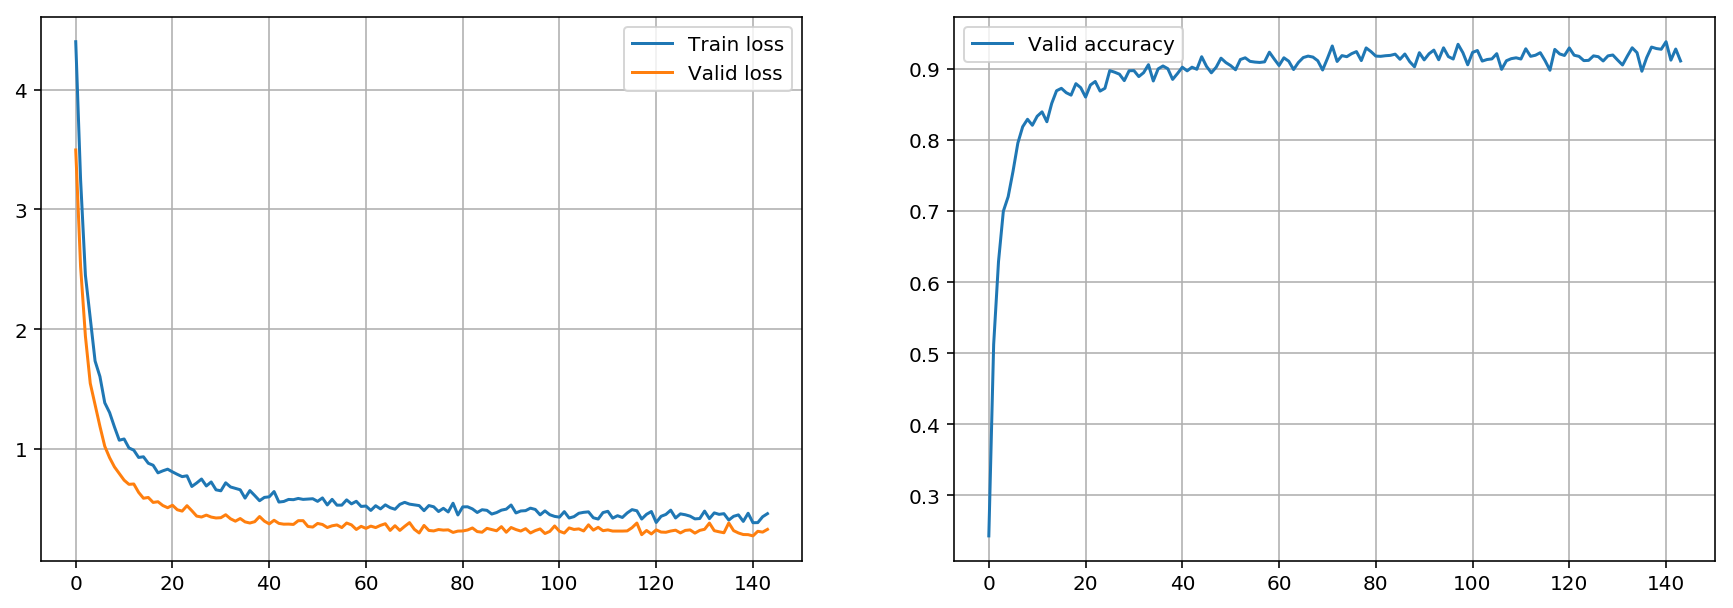

In [11]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(train_losses, label="Train loss")
ax.plot(valid_losses, label="Valid loss")
ax.legend()
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(valid_accuracies, label="Valid accuracy")
ax.legend()
ax.grid()